<font color="#6E6E6E"><h2 align="left">Text Analytics - Autoencoder</h2></font>

In [1]:
COLAB = True

 Analysis of a subset of a complaints dataset using 2 classes.

## Import main libraries

In [2]:
import nltk # !pip install nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

lemmatizer = WordNetLemmatizer().lemmatize

In [3]:
def show_model(model):
    display(SVG(model_to_dot(model,show_shapes=True,dpi=72).create(prog='dot', format='svg')))

## Load dataset ("corpus")

In [4]:
# El dataset está en:
# https://drive.google.com/file/d/1LFW1GSVkZXyXKFUdKNZA8alKK64d5J9P

if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1LFW1GSVkZXyXKFUdKNZA8alKK64d5J9P',
                                        dest_path='./reporting_complaints_2classes.csv')

In [5]:
# Read the input
df = pd.read_csv("./reporting_complaints_2classes.csv") # the dataset is loaded into a Pandas DataFrame
print(df.shape)

(10000, 2)


In [6]:
df.sample(10)

,consumer_complaint_narrative,product
1948,"For the last few years, I have been receiving ...",Credit card
5103,I have been paying an interest only for ten ye...,Mortgage
6729,My mortgage company Ocwen loan services keeps ...,Mortgage
1900,Hello : My wife returned from XXXX last XXXX X...,Credit card
6926,There is a foreclosure sale scheduled for a lo...,Mortgage
4540,I have visa credit for 6 yr never mists any pa...,Credit card
5081,I have been addressing these issues since XX/X...,Mortgage
6207,I originally obtained a loan through XXXX for ...,Mortgage
1084,I was an authorized user of American Express b...,Credit card
6856,My husband had a XXXX XXXX XXXX 3 years ago an...,Mortgage


In [7]:
df['product'].value_counts()

Credit card    5000
Mortgage       5000
Name: product, dtype: int64

In [8]:
narratives = list(df['consumer_complaint_narrative'])
labels = np.array(df['product'])
print("Number of narratives: {}".format(len(narratives)))

Number of narratives: 10000


In [9]:
case = 5
print("Type of product:", labels[case])
narratives[case]

Type of product: Credit card


"Yesterday, XXXX/XXXX/2015, after placing an order at XXXX, I received a security alert from discover card saying that there was a hold on the order. I called discover card and the call was passed on to the security customer service. When I asked why they placed the hold on the order the agent said 'walmart red flagged the order '. I could not understand why this was done. I called XXXX and they said that they did not put a hold or an alert on the card but that Discover card did. \r\nI then called back Discover card to find out what the problem was XXXX I have {$3700.00} credit line with only XXXX outstanding charge of about {$51.00}. ) I went around in circles trying to find out why this order was red flagged each customer service rep. including their so called 'executive office of customer advocacy ' gave me the same story, 'we do n't know. \r\nThey also had the online order of {$51.00} in pending status but they took that down yesterday. I called the online store where the purchase 

## Preprocessing

## Training-test split

In [10]:
Nval = 1000

from sklearn.model_selection import train_test_split

narratives_trval, narratives_te, y_trval, y_te = train_test_split(narratives, labels,
                                                                  test_size=0.3, random_state=1)

narratives_tr = narratives_trval[:-Nval]
y_tr = y_trval[:-Nval]

narratives_val = narratives_trval[-Nval:]
y_val = y_trval[-Nval:]

print("Number of training examples:", len(y_tr))
print("Number of validation examples:", len(y_val))
print("Number of test examples:", len(y_te))

Number of training examples: 6000
Number of validation examples: 1000
Number of test examples: 3000


### Creation / load of stopwords list

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
stop_words = stopwords.words('english')

for i in range(1,21):
    stop_words.append(i*'x')
print(stop_words) # alphabetical sort

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### Punctuation marks

In [15]:
from string import punctuation
punctuation_marks = list(punctuation)
print(punctuation_marks)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']


In [16]:
stop_words_and_punctuation = sorted(list(set(stop_words + punctuation_marks)))
print(stop_words_and_punctuation)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', 'a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'oursel

In [17]:
case = 2
text = narratives_tr[case]
text

'I have a credit card account with Best Buy and their processing issue caused my payment to show up as late even though I provided proof that I sent the automatic payment within the needed time frame just as I had for the previous year. They have added negative items to my credit report due to their error and I would like them removed. I feel that their business practices made it so that my payment would show as late and they could collect a late fee they were not entitled too. \r\n'

## Bag-of-words (BOW) representation

In [18]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
TF_vectorizer = CountVectorizer(max_features=1000, # max_df=0.5, min_df=20,
                                min_df=0.05,
                                stop_words=stop_words_and_punctuation)

TF_vectorizer

CountVectorizer(max_features=1000, min_df=0.05,
                stop_words=['!', '"', '#', '$', '%', '&', "'", '(', ')', '*',
                            '+', ',', '-', '.', '/', ':', ';', '<', '=', '>',
                            '?', '@', '[', '\\', ']', '^', '_', '`', 'a',
                            'about', ...])

In [19]:
stop_words_and_punctuation

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'need

In [20]:
TF_vectorizer.fit(narratives_tr)
tf_tr = TF_vectorizer.transform(narratives_tr)
TF_vocabulary = TF_vectorizer.get_feature_names_out()

In [21]:
print(len(TF_vocabulary))
print(TF_vocabulary)

331
['00' '10' '15' '2015' '30' 'able' 'account' 'accounts' 'additional'
 'address' 'advised' 'ago' 'agreed' 'agreement' 'almost' 'already' 'also'
 'always' 'america' 'amount' 'another' 'answer' 'anything' 'application'
 'applied' 'apply' 'approved' 'around' 'ask' 'asked' 'asking' 'attached'
 'attorney' 'back' 'balance' 'bank' 'based' 'behind' 'believe' 'bill'
 'business' 'ca' 'call' 'called' 'calling' 'calls' 'came' 'card' 'cards'
 'care' 'case' 'cfpb' 'change' 'changed' 'charge' 'charged' 'charges'
 'chase' 'check' 'claim' 'close' 'closed' 'closing' 'company' 'complaint'
 'complete' 'consumer' 'contact' 'contacted' 'continue' 'copy' 'correct'
 'could' 'credit' 'current' 'customer' 'date' 'day' 'days' 'debt' 'denied'
 'department' 'different' 'dispute' 'documentation' 'documents' 'done'
 'due' 'either' 'email' 'end' 'escrow' 'even' 'ever' 'every' 'everything'
 'explained' 'fact' 'fargo' 'fee' 'feel' 'fees' 'file' 'filed' 'finally'
 'financial' 'find' 'first' 'following' 'foreclosure' 

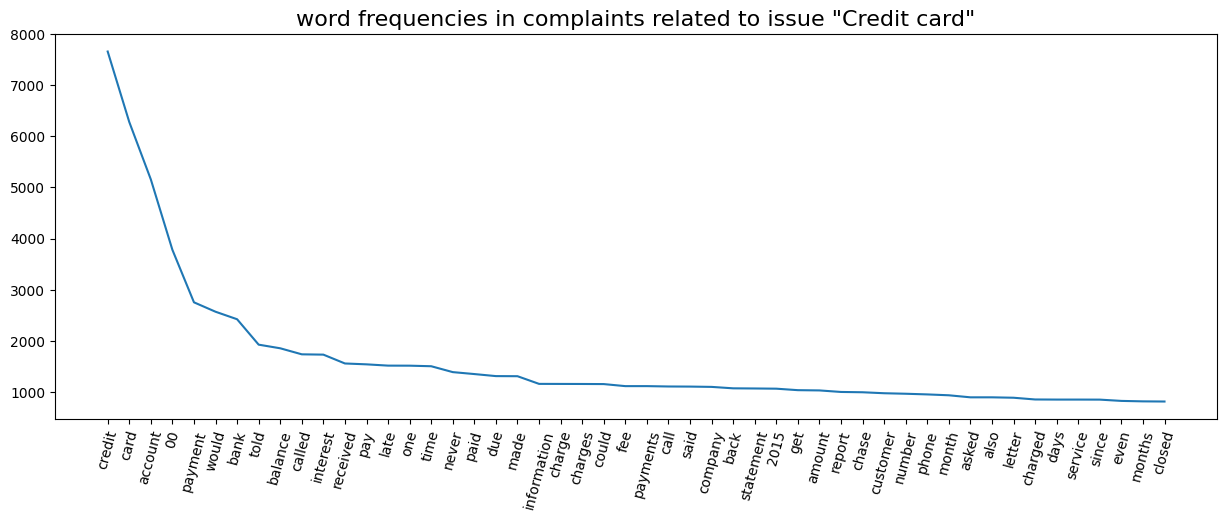

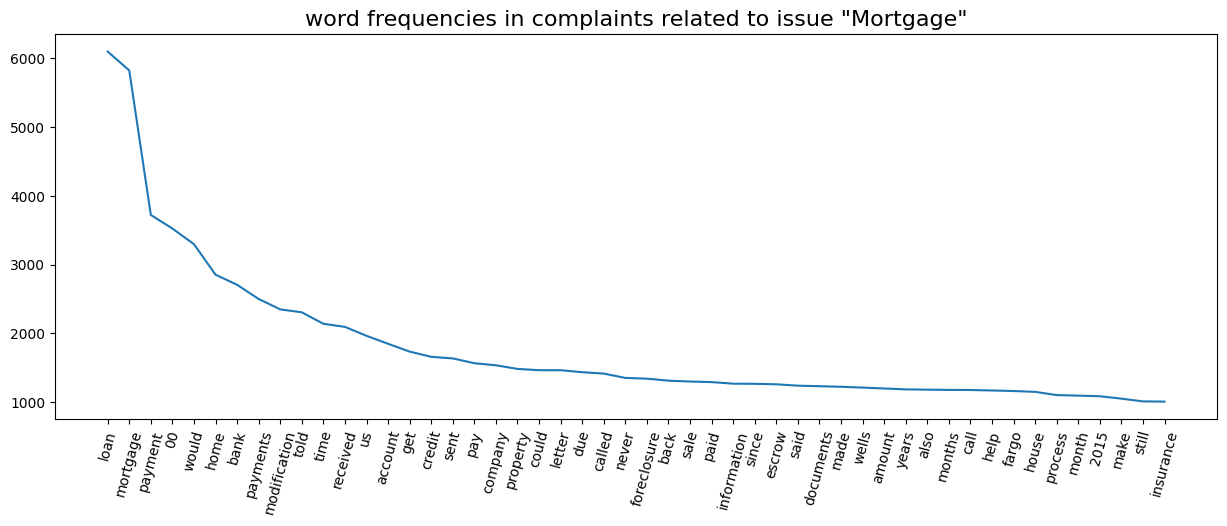

In [22]:
n=50
unique_labels = np.unique(labels)
for label in unique_labels:
    freqs = np.array(tf_tr[y_tr==label].sum(axis=0))[0]
    plt.figure(figsize=(15,5))
    inds = np.argsort(freqs)[::-1]
    plt.plot(freqs[inds[:n]])
    plt.xticks(range(n), np.array(TF_vocabulary)[inds[:n]], rotation=75)
    plt.title('word frequencies in complaints related to issue ' + '"'+label+'"', fontsize=16)
    plt.show()

## TF-IDF

In [23]:
TFIDF_vectorizer = TfidfVectorizer(max_features=1000,
                                   min_df=0.05,
                                   stop_words=stop_words_and_punctuation,
                                   norm='l2')
print(TFIDF_vectorizer)

X_tr  = np.array(TFIDF_vectorizer.fit_transform(narratives_tr).todense(),
                 dtype=np.float16)
X_te  = np.array(TFIDF_vectorizer.transform(narratives_te).todense(),
                 dtype=np.float16)
X_val = np.array(TFIDF_vectorizer.transform(narratives_val).todense(),
                 dtype=np.float16)

TFIDF_vocabulary = TFIDF_vectorizer.get_feature_names_out()

TfidfVectorizer(max_features=1000, min_df=0.05,
                stop_words=['!', '"', '#', '$', '%', '&', "'", '(', ')', '*',
                            '+', ',', '-', '.', '/', ':', ';', '<', '=', '>',
                            '?', '@', '[', '\\', ']', '^', '_', '`', 'a',
                            'about', ...])


In [24]:
len(TFIDF_vocabulary)

331

In [25]:
print(TFIDF_vocabulary)

['00' '10' '15' '2015' '30' 'able' 'account' 'accounts' 'additional'
 'address' 'advised' 'ago' 'agreed' 'agreement' 'almost' 'already' 'also'
 'always' 'america' 'amount' 'another' 'answer' 'anything' 'application'
 'applied' 'apply' 'approved' 'around' 'ask' 'asked' 'asking' 'attached'
 'attorney' 'back' 'balance' 'bank' 'based' 'behind' 'believe' 'bill'
 'business' 'ca' 'call' 'called' 'calling' 'calls' 'came' 'card' 'cards'
 'care' 'case' 'cfpb' 'change' 'changed' 'charge' 'charged' 'charges'
 'chase' 'check' 'claim' 'close' 'closed' 'closing' 'company' 'complaint'
 'complete' 'consumer' 'contact' 'contacted' 'continue' 'copy' 'correct'
 'could' 'credit' 'current' 'customer' 'date' 'day' 'days' 'debt' 'denied'
 'department' 'different' 'dispute' 'documentation' 'documents' 'done'
 'due' 'either' 'email' 'end' 'escrow' 'even' 'ever' 'every' 'everything'
 'explained' 'fact' 'fargo' 'fee' 'feel' 'fees' 'file' 'filed' 'finally'
 'financial' 'find' 'first' 'following' 'foreclosure' 'fou

### Majority class (baseline)

In [26]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy='most_frequent')
clf.fit(X_tr, y_tr)
print("score en training :", clf.score(X_tr, y_tr).round(3))
print("score en test     :", clf.score(X_te, y_te).round(3))

score en training : 0.501
score en test     : 0.5


## Autoencoder

In [27]:
X_tr.shape, X_val.shape, X_te.shape

((6000, 331), (1000, 331), (3000, 331))

In [28]:
(X_tr == 0).mean()

0.8899436052366566

In [29]:
np.unique(y_tr)

array(['Credit card', 'Mortgage'], dtype=object)

In [30]:
y_tr_int = 1*(y_tr=="Credit card")
y_te_int = 1*(y_te=="Credit card")

In [31]:
# knn works better with normalized X_proy_tr, normalized X_proy_te

In [32]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint

In [33]:
def grafica_entrenamiento(tr_loss, val_loss):
    ax=plt.figure(figsize=(10,4)).gca()
    plt.plot(1+np.arange(len(tr_loss)), tr_loss)
    plt.plot(1+np.arange(len(val_loss)), val_loss)
    plt.title('loss del modelo', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.ylabel('mse', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [34]:
loss = "mse"

In [35]:
dense_1 = keras.layers.Dense(2, use_bias=False) # capa lineal densa
dense_2 = keras.layers.Dense(X_tr.shape[1], use_bias=False)

encoder = keras.models.Sequential([dense_1])
decoder = keras.models.Sequential([dense_2])

ae = keras.models.Sequential([encoder, decoder])

#ae.compile(loss=loss, optimizer=keras.optimizers.SGD(learning_rate=0.5))
#ae.compile(loss=loss, optimizer=keras.optimizers.SGD(learning_rate=1.5))
ae.compile(loss=loss, optimizer="adam")

In [36]:
modelpath="model_current_best.h5"
checkpoint = ModelCheckpoint(modelpath, monitor='val_loss',
                             verbose=2,
                             save_best_only=True,
                             mode='min') # graba sólo los que mejoran en validación

callbacks_list = [checkpoint]

In [37]:
epochs = 100
batch_size = 64

acum_tr_loss = []
acum_val_loss = []


Epoch 1: val_loss improved from inf to 0.00280, saving model to model_current_best.h5

Epoch 1: val_loss improved from 0.00280 to 0.00265, saving model to model_current_best.h5

Epoch 1: val_loss improved from 0.00265 to 0.00262, saving model to model_current_best.h5

Epoch 1: val_loss improved from 0.00262 to 0.00257, saving model to model_current_best.h5

Epoch 1: val_loss improved from 0.00257 to 0.00255, saving model to model_current_best.h5

Epoch 1: val_loss improved from 0.00255 to 0.00255, saving model to model_current_best.h5

Epoch 1: val_loss improved from 0.00255 to 0.00254, saving model to model_current_best.h5

Epoch 1: val_loss improved from 0.00254 to 0.00254, saving model to model_current_best.h5

Epoch 1: val_loss improved from 0.00254 to 0.00254, saving model to model_current_best.h5

Epoch 1: val_loss improved from 0.00254 to 0.00254, saving model to model_current_best.h5

Epoch 1: val_loss improved from 0.00254 to 0.00254, saving model to model_current_best.h5

Ep

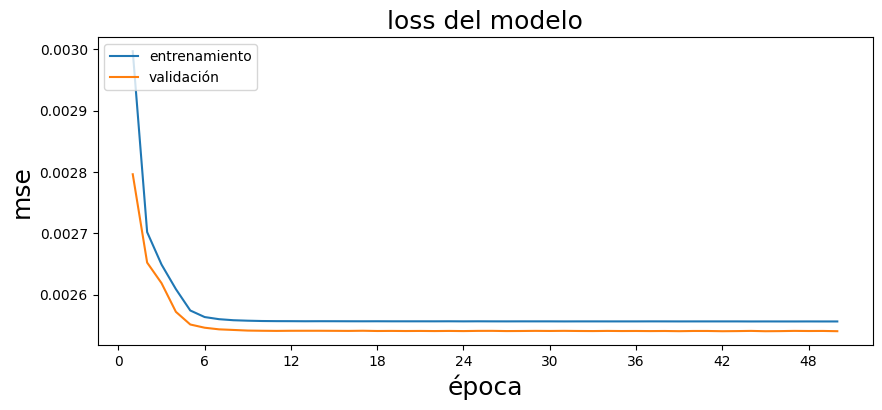


Epoch 1: val_loss did not improve from 0.00254

Epoch 1: val_loss did not improve from 0.00254

Epoch 1: val_loss did not improve from 0.00254

Epoch 1: val_loss did not improve from 0.00254

Epoch 1: val_loss did not improve from 0.00254

Epoch 1: val_loss improved from 0.00254 to 0.00254, saving model to model_current_best.h5

Epoch 1: val_loss did not improve from 0.00254

Epoch 1: val_loss did not improve from 0.00254

Epoch 1: val_loss did not improve from 0.00254

Epoch 1: val_loss did not improve from 0.00254

Epoch 1: val_loss did not improve from 0.00254

Epoch 1: val_loss did not improve from 0.00254

Epoch 1: val_loss did not improve from 0.00254

Epoch 1: val_loss did not improve from 0.00254

Epoch 1: val_loss did not improve from 0.00254

Epoch 1: val_loss did not improve from 0.00254

Epoch 1: val_loss did not improve from 0.00254

Epoch 1: val_loss did not improve from 0.00254

Epoch 1: val_loss did not improve from 0.00254

Epoch 1: val_loss did not improve from 0.002

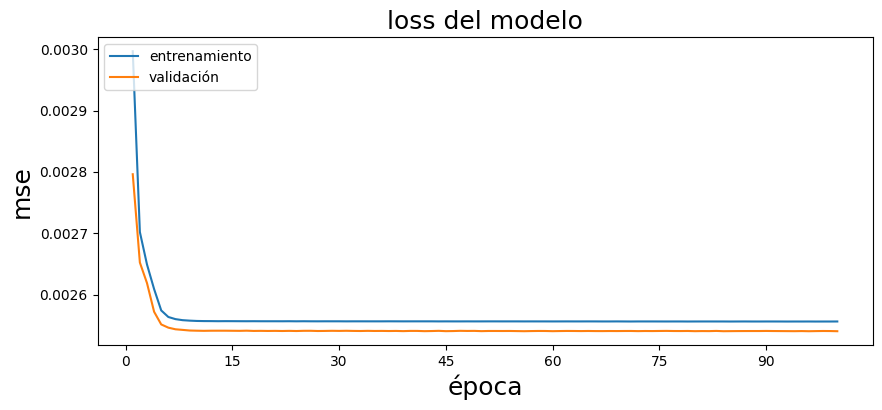

In [38]:
for e in range(epochs):
    history = ae.fit(X_tr, X_tr,
                     batch_size=batch_size,
                     epochs=1,
                     callbacks=callbacks_list,
                     verbose=0,
                     validation_data=(X_val, X_val))

    acum_tr_loss  += history.history['loss']
    acum_val_loss += history.history['val_loss']
    
    if (e+1)%50 == 0:
        grafica_entrenamiento(acum_tr_loss, acum_val_loss)

In [39]:
ae = keras.models.load_model(modelpath)

In [40]:
ae.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 2)                 662       
                                                                 
 sequential_1 (Sequential)   (None, 331)               662       
                                                                 
Total params: 1,324
Trainable params: 1,324
Non-trainable params: 0
_________________________________________________________________


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 662       
                                                                 
Total params: 662
Trainable params: 662
Non-trainable params: 0
_________________________________________________________________


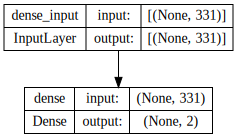

In [41]:
encoder.summary()

show_model(encoder)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 331)               662       
                                                                 
Total params: 662
Trainable params: 662
Non-trainable params: 0
_________________________________________________________________


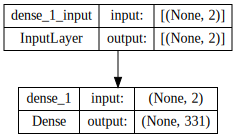

In [42]:
decoder.summary()

show_model(decoder)

In [43]:
print("loss en training :", ((np.array(X_tr) - ae.predict(X_tr))**2).mean())
print("loss en test     :", ((np.array(X_te) - ae.predict(X_te))**2).mean())

188/188 [==============================] - 1s 4ms/step
loss en training : 0.002554976
94/94 [==============================] - 0s 4ms/step
loss en test     : 0.002561661


## Visualización del embedding aprendido

In [44]:
doc_vecs_tr  = encoder.predict(X_tr)
doc_vecs_val = encoder.predict(X_val)
doc_vecs_te  = encoder.predict(X_te)
word_vecs = decoder.get_weights()[0].T

94/94 [==============================] - 0s 4ms/step


In [45]:
doc_vecs_tr.shape, doc_vecs_val.shape, doc_vecs_te.shape, word_vecs.shape

((6000, 2), (1000, 2), (3000, 2), (331, 2))

In [46]:
W1 = ae.layers[0].get_weights()[0]
W2 = ae.layers[1].get_weights()[0]

In [47]:
W2.dot(W1).round(3)

array([[ 0.998,  0.001],
       [-0.001,  0.999]], dtype=float32)

In [48]:
# importing bokeh library for interactive dataviz

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool, LabelSet, ColumnDataSource, Range1d
from bokeh.plotting import figure, show, output_notebook

output_notebook()
p = bp.figure(plot_width=700, plot_height=600, title="words in latent dimensions",
              tools="pan,wheel_zoom,box_zoom,reset,hover,save",
              x_axis_label='lat 0',
              y_axis_label='lat 1',
              #x_axis_type=None, y_axis_type=None,
              min_border=1)
p.title.text_font_size='16pt'
p.xaxis.axis_label_text_font_style='normal'
p.xaxis.axis_label_text_font_size='16pt'
p.yaxis.axis_label_text_font_style='normal'
p.yaxis.axis_label_text_font_size='16pt'

p.xgrid.visible = False
p.ygrid.visible = False

dictf = {'x':word_vecs[:,0],
         'y':word_vecs[:,1],
         'words':TFIDF_vocabulary}
aa = ColumnDataSource(dictf)
p.scatter(x='x', y='y', source=aa)
labels_p = LabelSet(x='x', y='y', text='words',
                    level='glyph',
                    x_offset=5, y_offset=5, source=aa, render_mode='canvas')
p.add_layout(labels_p)

hover = p.select(dict(type=HoverTool))
hover.tooltips={"word": "@words"}
show(p)

In [49]:
from sklearn.metrics.pairwise import pairwise_distances

index2word = np.array(TFIDF_vocabulary)
word2index = {w:i for i,w in enumerate(index2word)}

def most_similar_words(word,wordvecs,n=10):
    n_latent_dimensions = np.shape(wordvecs)[1]
    ind = word2index[word]
    aux = np.reshape(wordvecs[ind,:], (1,n_latent_dimensions))
    dists = pairwise_distances(aux, wordvecs).flatten()
    inds = dists.argsort().tolist()
    inds.remove(ind)
    return index2word[inds[:n]]

In [50]:
len(TFIDF_vocabulary)

331

In [51]:
most_similar_words('debt', word_vecs)

array(['mail', 'issue', 'receive', 'however', 'applied', 'day',
       'informed', 'past', 'contacted', 'like'], dtype=object)

In [52]:
most_similar_words('card', word_vecs)

array(['credit', 'account', 'balance', 'report', 'fee', 'charges',
       'charge', 'late', '00', 'one'], dtype=object)

In [53]:
most_similar_words('loan', word_vecs)

array(['mortgage', 'modification', 'home', 'us', 'payments',
       'foreclosure', 'property', 'payment', 'sale', 'house'],
      dtype=object)

In [54]:
most_similar_words('call', word_vecs)

array(['back', 'said', 'amount', 'month', 'also', 'information', 'months',
       '2015', 'could', 'since'], dtype=object)

In [55]:
most_similar_words('bank', word_vecs)

array(['would', '00', 'told', 'interest', 'payment', 'pay', 'received',
       'late', 'time', 'called'], dtype=object)

In [56]:
most_similar_words('home', word_vecs)

array(['modification', 'us', 'payments', 'property', 'foreclosure',
       'sale', 'house', 'wells', 'fargo', 'escrow'], dtype=object)

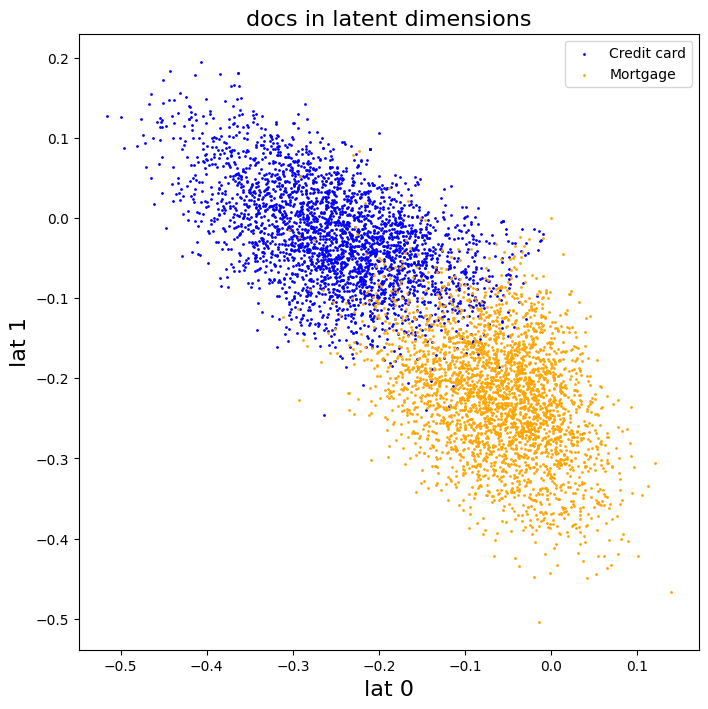

In [57]:
colors = ['blue', 'orange']

plt.figure(figsize=(8,8))
for i,label in enumerate(unique_labels):
    plt.scatter(doc_vecs_tr[y_tr==label,0],
                doc_vecs_tr[y_tr==label,1],
                s = 1, alpha = 1, c = colors[i], label=label,
                )
plt.legend()
plt.xlabel('lat 0', fontsize=16)
plt.ylabel('lat 1', fontsize=16)
plt.title('docs in latent dimensions', fontsize=16);

In [58]:
def most_similar_docs(doc, wordvecs, docvecs, n=10):
    n_latent_dimensions = np.shape(wordvecs)[1]
    aux = np.reshape(doc, (1,n_latent_dimensions))
    dists = pairwise_distances(aux, docvecs).flatten()
    inds = dists.argsort().tolist()
    return inds[:n]

In [59]:
caso = 0

doc_inds = most_similar_docs(doc_vecs_te[caso], word_vecs, doc_vecs_tr)

start_bold = '\033[1m'
end_bold   = '\033[0m'

print(start_bold + "document {} in test:".format(caso) + end_bold)
print(narratives_te[caso])
print(start_bold + "Most similar documents in training:" + end_bold)
for i,ind in enumerate(doc_inds):
    print(start_bold + "* doc {} in training:".format(i) + end_bold)
    print(narratives_tr[ind])

document 0 in test:
After messing up my escrow XXXX sold my mortgage to Carrington Mortgage Services as of XXXX/XXXX/2015. I made my XXXX payment to XXXX and the check was cashed as of XX/XX/XXXX. Carrington has been harassing me over the payment since XX/XX/XXXX, and has been notified several times that the payment was made to XXXX in XX/XX/XXXX. 

Most similar documents in training:
* doc 0 in training:
For 8 months I worked with Discover Home Loans on a mortgage. They approved my initial request, locked in the rate and gave me a " close on time guarantee. '' At one point I asked to increase the amount of the loan ( when I was worried my house would n't sell before the new house was done ). I was told that increase was approved. Then my house sold and I requested that they go back to the original amount approved. That was 2 months before closing on my new house. They continually assured me that my mortgage was approved. Before XXXX XXXX, 2015 they knew the closing date of XXXX XXXX, 

In [60]:
# defining the chart
output_notebook()
p = bp.figure(plot_width=700, plot_height=600, title="docs in latent dimensions",
              tools="pan,wheel_zoom,box_zoom,reset,hover,save",
              x_axis_label='lat 0',
              y_axis_label='lat 1',
              #x_axis_type=None, y_axis_type=None,
              min_border=1)
p.title.text_font_size = '16pt'
p.xaxis.axis_label_text_font_style='normal'
p.xaxis.axis_label_text_font_size='16pt'
p.yaxis.axis_label_text_font_style='normal'
p.yaxis.axis_label_text_font_size='16pt'

p.xgrid.visible = False
p.ygrid.visible = False

for i,label in enumerate(unique_labels):
    inds = np.where(y_tr==label)[0]
    dictf = {'x':doc_vecs_tr[inds,0],
             'y':doc_vecs_tr[inds,1],
             'text':np.array(narratives_tr)[y_tr==label],
             'ind':inds}
    aa = ColumnDataSource(dictf)
    p.scatter(x='x', y='y', source=aa,
              color=colors[i], legend=label)

hover = p.select(dict(type=HoverTool))
hover.tooltips={"text": "@text", "index in tr": "@ind"}
show(p)

Output hidden; open in https://colab.research.google.com to view.

## Construction of classification models

### Naïve Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(doc_vecs_tr, y_tr)
print("score en training :", clf.score(doc_vecs_tr, y_tr).round(3))
print("score en test     :", clf.score(doc_vecs_te, y_te).round(3))


### Support Vector Machines

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [ ]:
print(doc_vecs_tr.var(axis=0))

clf = Pipeline(
    [("scaler", StandardScaler()),
     ("SVC", SVC(kernel='rbf'))]
)

clf.fit(doc_vecs_tr, y_tr)
print("score en training :", clf.score(doc_vecs_tr, y_tr).round(3))
print("score en test     :", clf.score(doc_vecs_te, y_te).round(3))


### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = Pipeline(
    [("scaler", StandardScaler()),
     ("LogReg", LogisticRegression())]
)

clf.fit(doc_vecs_tr, y_tr)
print("score en training :", clf.score(doc_vecs_tr, y_tr).round(3))
print("score en test     :", clf.score(doc_vecs_te, y_te).round(3))

In [ ]:
from sklearn.metrics import classification_report, roc_curve, auc

col_clase_positiva = 1
y_pred_proba = clf.predict_proba(doc_vecs_te)
y_pred = clf.predict(doc_vecs_te)
print('')
print(classification_report(y_te, y_pred))

In [ ]:
colors2 = ['r', 'g', 'm', 'c', 'y']
plt.figure(figsize=(7,5))
for i,l in enumerate(unique_labels):
    fpr, tpr, thresholds = roc_curve(y_te, y_pred_proba[:,i], pos_label=unique_labels[i])
    plt.plot(fpr, tpr, colors2[i]+'-.', label=l+' (%2.2f)' % auc(fpr, tpr))
plt.plot(fpr, fpr, 'b-', label = 'Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend();

# Clustering

In [ ]:
scaler = StandardScaler()
X_km   = scaler.fit_transform(doc_vecs_tr)

X_km = doc_vecs_tr

## k-means

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score as qmetric

Nrepetitions = 10

qualities = []
inertias = []
models = []
kini = 1
kfin = 10
for k in range(kini,kfin+1):
    print("Evaluando k=%d" % k)
    km = KMeans(n_clusters=k,
                init='k-means++', n_init=Nrepetitions,
                max_iter=500, random_state=2)    
    km.fit(X_km)
    models.append(km)
    inertias.append(km.inertia_)
    if k >1:
        qualities.append(qmetric(X_km, km.labels_))
    else:
        qualities.append(0)

In [ ]:
fig = plt.figure(figsize=(14,3))

ax = plt.subplot(1,2,1)
plt.plot(range(kini,kfin+1), inertias, marker='o')
plt.xlabel('number of clusters')
plt.title('clustering inertia')

ax = plt.subplot(1,2,2)
plt.plot(range(kini,kfin+1), qualities, marker='o')
plt.xlabel('number of clusters')
plt.title('clustering quality')
plt.show()

best = pd.Series(qualities).idxmax() # get index for the best model
km = models[best]
n_clusters = km.get_params()['n_clusters']
clusters = km.labels_
n_clusters

In [ ]:
def clustering_reporting(cluster_labels, clases):
    unique_clases = np.unique(clases)
    
    for i,c in enumerate(np.unique(cluster_labels)):
        inds = np.where(cluster_labels == c)[0]
        print("cluster %d (%.2f%%):" % (i,100*len(inds)/len(clases)))
        for c in unique_clases:
            print('   '+c+": %.2f%%" % (100*(clases[inds].tolist().count(c))/len(inds)))
        print()

In [ ]:
clustering_reporting(km.labels_, y_tr)